In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/home/wuxie/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


1.13.1


In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 13 columns):
0     115 non-null float64
1     115 non-null float64
2     115 non-null float64
3     115 non-null float64
4     115 non-null float64
5     115 non-null float64
6     115 non-null float64
7     115 non-null float64
8     115 non-null float64
9     115 non-null float64
10    115 non-null float64
11    115 non-null float64
12    115 non-null float64
dtypes: float64(13)
memory usage: 11.8 KB


# 分割数据集
把数据集分割为训练集和测试集。

测试集在最后验证评估的时候使用。

In [3]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

# 观察数据
使用seaborn观察数据分布情况

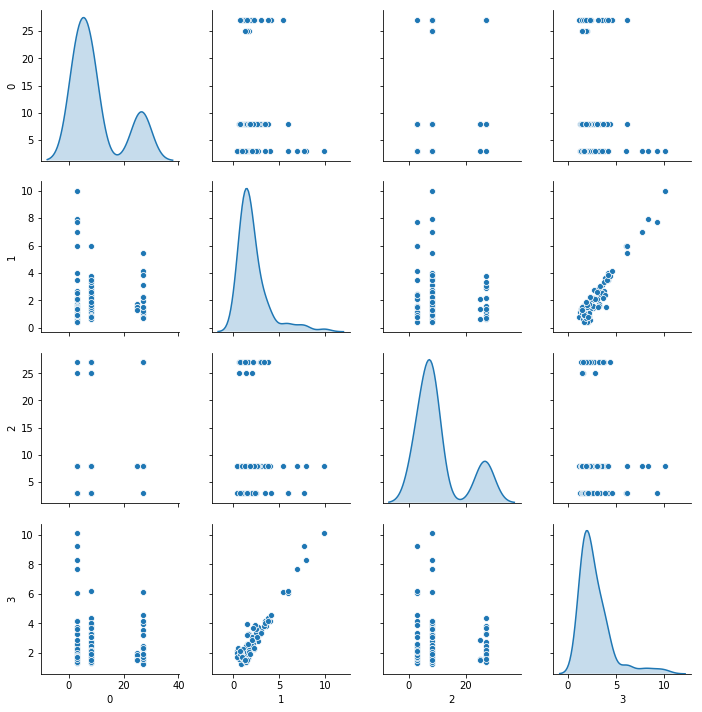

In [4]:
sns.pairplot(train_dataset[["0", "1", "2", "3"]], diag_kind="kde")

数据统计：

In [5]:
train_stats = train_dataset.describe()
train_stats.pop("12")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
0,92.0,10.010870,9.025598,3.000000,3.000000,8.000000,8.000000,27.000000
1,92.0,2.150662,1.719899,0.415123,1.224625,1.575977,2.383212,9.968198
2,92.0,10.456522,8.305186,3.000000,8.000000,8.000000,8.000000,27.000000
3,92.0,2.827173,1.688494,1.225290,1.703927,2.243113,3.266560,10.116105
4,92.0,10.945652,9.009597,3.000000,3.000000,8.000000,8.000000,27.000000
5,92.0,3.344718,1.776509,1.600473,2.224705,2.757124,3.750743,10.238871
6,92.0,11.945652,9.175174,3.000000,8.000000,8.000000,25.000000,27.000000
7,92.0,3.840941,1.931054,1.766634,2.640612,3.272354,4.133824,10.578477
8,92.0,12.010870,9.780553,3.000000,3.000000,8.000000,25.000000,27.000000
9,92.0,4.486299,3.022687,1.819963,3.058726,3.599045,4.895187,25.233009


>其中count 代表总数量，mean代表均值，std代表标准差 (standard deviation)，min代表最小值，max代表最大值

# 从数据集中提取Eb值
Eb值是我们训练模型来预测的值，所以要将其从数据集中提取出来作为labels

In [6]:
train_labels = train_dataset.pop('12')
test_labels = test_dataset.pop('12')

# 标准化数据
从train_stats表格里面的数据，我们可以看出数据特征范围的差异性有多大。

In [7]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

标准化之后的数据统计：

In [8]:
normed_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,92.0,5.249424e-17,1.0,-0.776776,-0.776776,-0.222796,-0.222796,1.882327
1,92.0,2.229497e-16,1.0,-1.009094,-0.538425,-0.334138,0.135212,4.545347
2,92.0,-6.214835e-17,1.0,-0.897815,-0.295782,-0.295782,-0.295782,1.991946
3,92.0,-6.033821e-17,1.0,-0.948705,-0.665236,-0.345906,0.260224,4.316826
4,92.0,9.654113e-17,1.0,-0.881910,-0.881910,-0.326946,-0.326946,1.781916
5,92.0,5.358033e-16,1.0,-0.981838,-0.630457,-0.330758,0.228553,3.880730
6,92.0,5.913144e-17,1.0,-0.974984,-0.430036,-0.430036,1.422790,1.640770
7,92.0,2.775558e-17,1.0,-1.074184,-0.621593,-0.294444,0.151670,3.489046
8,92.0,8.205996e-17,1.0,-0.921305,-0.921305,-0.410086,1.328057,1.532544
9,92.0,-1.405880e-16,1.0,-0.882108,-0.472286,-0.293532,0.135273,6.863665


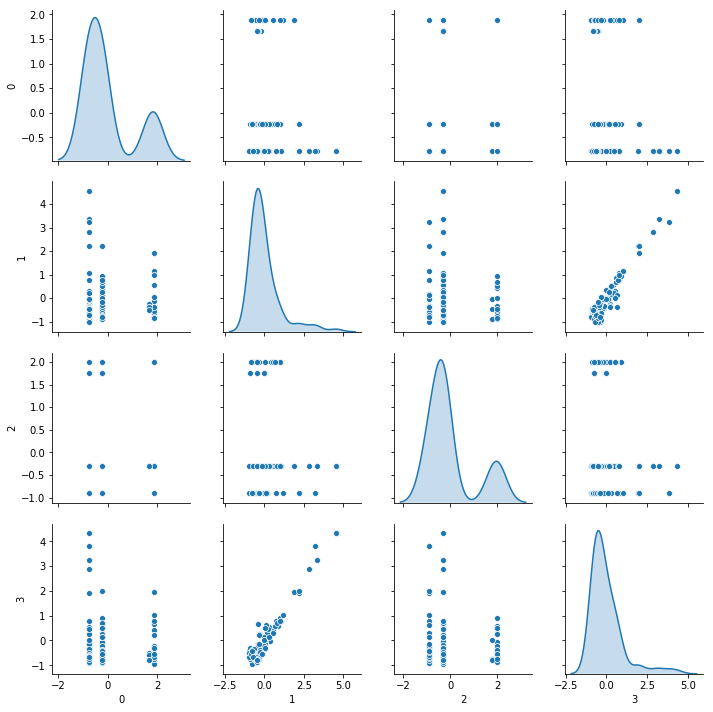

In [9]:
sns.pairplot(normed_train_data[["0", "1", "2",'3']], diag_kind="kde")

# 构建模型
我们使用Sequential模型，添加两个全连接的Dense layers，一个大小为1的Dense layer，作为预测结果。

In [10]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
      layers.Dense(64, activation=tf.nn.relu),
      layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [11]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# 查看模型

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


取前10个样本来做预测尝试看看程序是否能正确运行：

In [13]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16374087],
       [ 0.23761283],
       [-0.06668545],
       [-0.29000995],
       [ 0.23717313],
       [ 0.00955044],
       [ 0.23907065],
       [-0.06546959],
       [-0.058497  ],
       [ 0.27883375]], dtype=float32)

# 训练模型
训练100批次，同时记录下训练和验证的准确率。

In [14]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................

利用pandas把训练记录可视化：

In [15]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,7.981056,1.910427,7.981056,16.510168,2.979990,16.510168,95
96,7.675995,1.932149,7.675995,15.252443,2.802171,15.252443,96
97,7.578228,1.859142,7.578228,14.542194,2.693715,14.542194,97
98,7.550057,1.823980,7.550057,14.841865,2.724935,14.841865,98
99,7.482722,1.816415,7.482723,14.304288,2.658557,14.304288,99


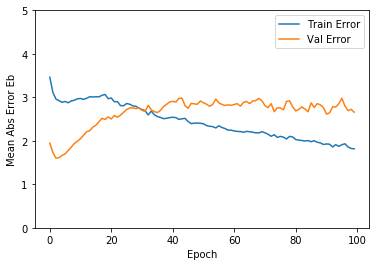

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error Eb')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.legend()
    plt.ylim([0,5])

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error [$Eb^2$]')
#     plt.plot(hist['epoch'], hist['mean_squared_error'],
#              label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#              label = 'Val Error')
#     plt.legend()
#     plt.ylim([0,20])

plot_history(history)

在大概60个批次之后，训练错误率降低，但验证错误率在上升。

我们需要在适当的时候使用EarlyStopping回调函数来测试每个批次的训练条件，如果经过一定数量的批次，还没有改进，则自动停止训练。


.......................

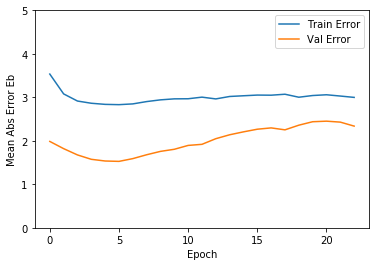

In [17]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

我们使用它来进行预测。测试集没有参与训练，测试集的测试结果将会向我们展示训练的模型在实际中效果如何。

In [18]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} Eb".format(mae))

Testing set Mean Abs Error:  2.76 Eb


# 做出预测

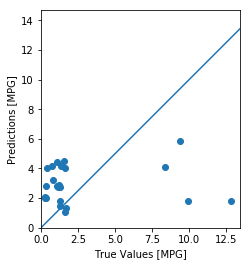

In [19]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

这张图x坐标代表实际值，y坐标代表预测值，所以当点越集中在中间那条反对角线的时候，说明预测越准。

看看错误的分布情况

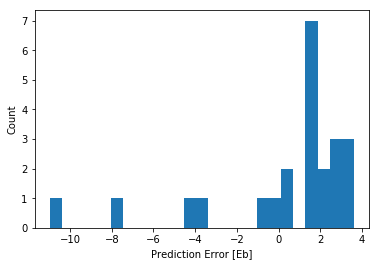

In [20]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Eb]")
_ = plt.ylabel("Count")

从图中得出，大多数预测结果大于实际值